In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json

plt.style.use('plot_style.txt')

In [2]:
OBJECTIVE = "OBJECTIVE"
INEQUALITY_CONSTRAINT_ONE = "INEQUALITY_CONSTRAINT_ONE"
INEQUALITY_CONSTRAINT_TWO = "INEQUALITY_CONSTRAINT_TWO"

In [6]:
def process_ts_results(result_dir: str,
                       num_runs: int,
                       failure_val: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        objective_vals = objective_vals * 10000
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))
    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [18]:
def process_original_albo_results(result_dir: str,
                                  num_runs: int,
                                  failure_val: float):
    all_results = []
    for run in range(1, num_runs + 1):
        run_file = result_dir + f"run_{run}_results.json"
        with open(run_file, "rb") as fp:
            all_run_data = json.load(fp)
            run_results = all_run_data["prog"]
            i = 0
            while run_results[i] == "Inf":
                i += 1
            if i > 0:
                for j in range(i):
                    run_results[j] = failure_val
            run_results = run_results
            all_results.append(run_results)
    all_results = np.array(all_results)
    all_results = np.multiply(all_results, 10000)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [19]:
original_albo_no_slack_results, original_albo_no_slack_results_mean, original_albo_no_slack_results_median, original_albo_no_slack_results_std = process_original_albo_results("../results/final_original_results/lockwood/no_slack/data/", 20, 6)
original_albo_slack_optim_results, original_albo_slack_optim_results_mean, original_albo_slack_optim_results_median, original_albo_slack_optim_results_std = process_original_albo_results("../results/final_original_results/lockwood/slack_optim/data/", 20, 6)
original_albo_slack_no_optim_results, original_albo_slack_no_optim_results_mean, original_albo_slack_no_optim_results_median, original_albo_slack_no_optim_results_std = process_original_albo_results("../results/final_original_results/lockwood/slack_no_optim/data/", 20, 6)
random_results, random_results_mean, random_results_median, random_results_std = process_ts_results("../results/20-04-23/lockwood_random/data/", 20, 60000)
ts_al_adam_results, ts_al_adam_results_mean, ts_al_adam_results_median, ts_al_adam_results_std = process_ts_results("../results/final_ts_results/lockwood/adam/data/", 20, 60000)
ts_al_adam_no_prev_results, ts_al_adam_no_prev_results_mean, ts_al_adam_no_prev_results_median, ts_al_adam_no_prev_results_std = process_ts_results("../results/final_ts_results/lockwood/adam_no_prev/data/", 20, 60000)
ts_al_adam_no_prev_rbf_results, ts_al_adam_no_prev_rbf_results_mean, ts_al_adam_no_prev_rbf_results_median, ts_al_adam_no_prev_rbf_results_std = process_ts_results("../results/final_ts_results/lockwood/adam_no_prev_rbf/data/", 20, 60000)
ts_al_random_rbf_results, ts_al_random_rbf_results_mean, ts_al_random_rbf_results_median, ts_al_random_rbf_results_std = process_ts_results("../results/final_ts_results/lockwood/no_opt_rbf/data/", 20, 60000)
ts_reduced_lbfgs_results, ts_reduced_lbfgs_results_mean, ts_reduced_lbfgs_results_median, ts_reduced_lbfgs_results_std = process_ts_results("../results/24-04-23/lockwood_6000_samples_2_bfgs/data/", 6, 60000)
# Don't think below used zero mean
ts_no_optim_results, ts_no_optim_results_mean, ts_no_optim_results_median, ts_no_optim_results_std = process_ts_results("../results/25-04-23/lockwood_no_optim/data/", 20, 60000)

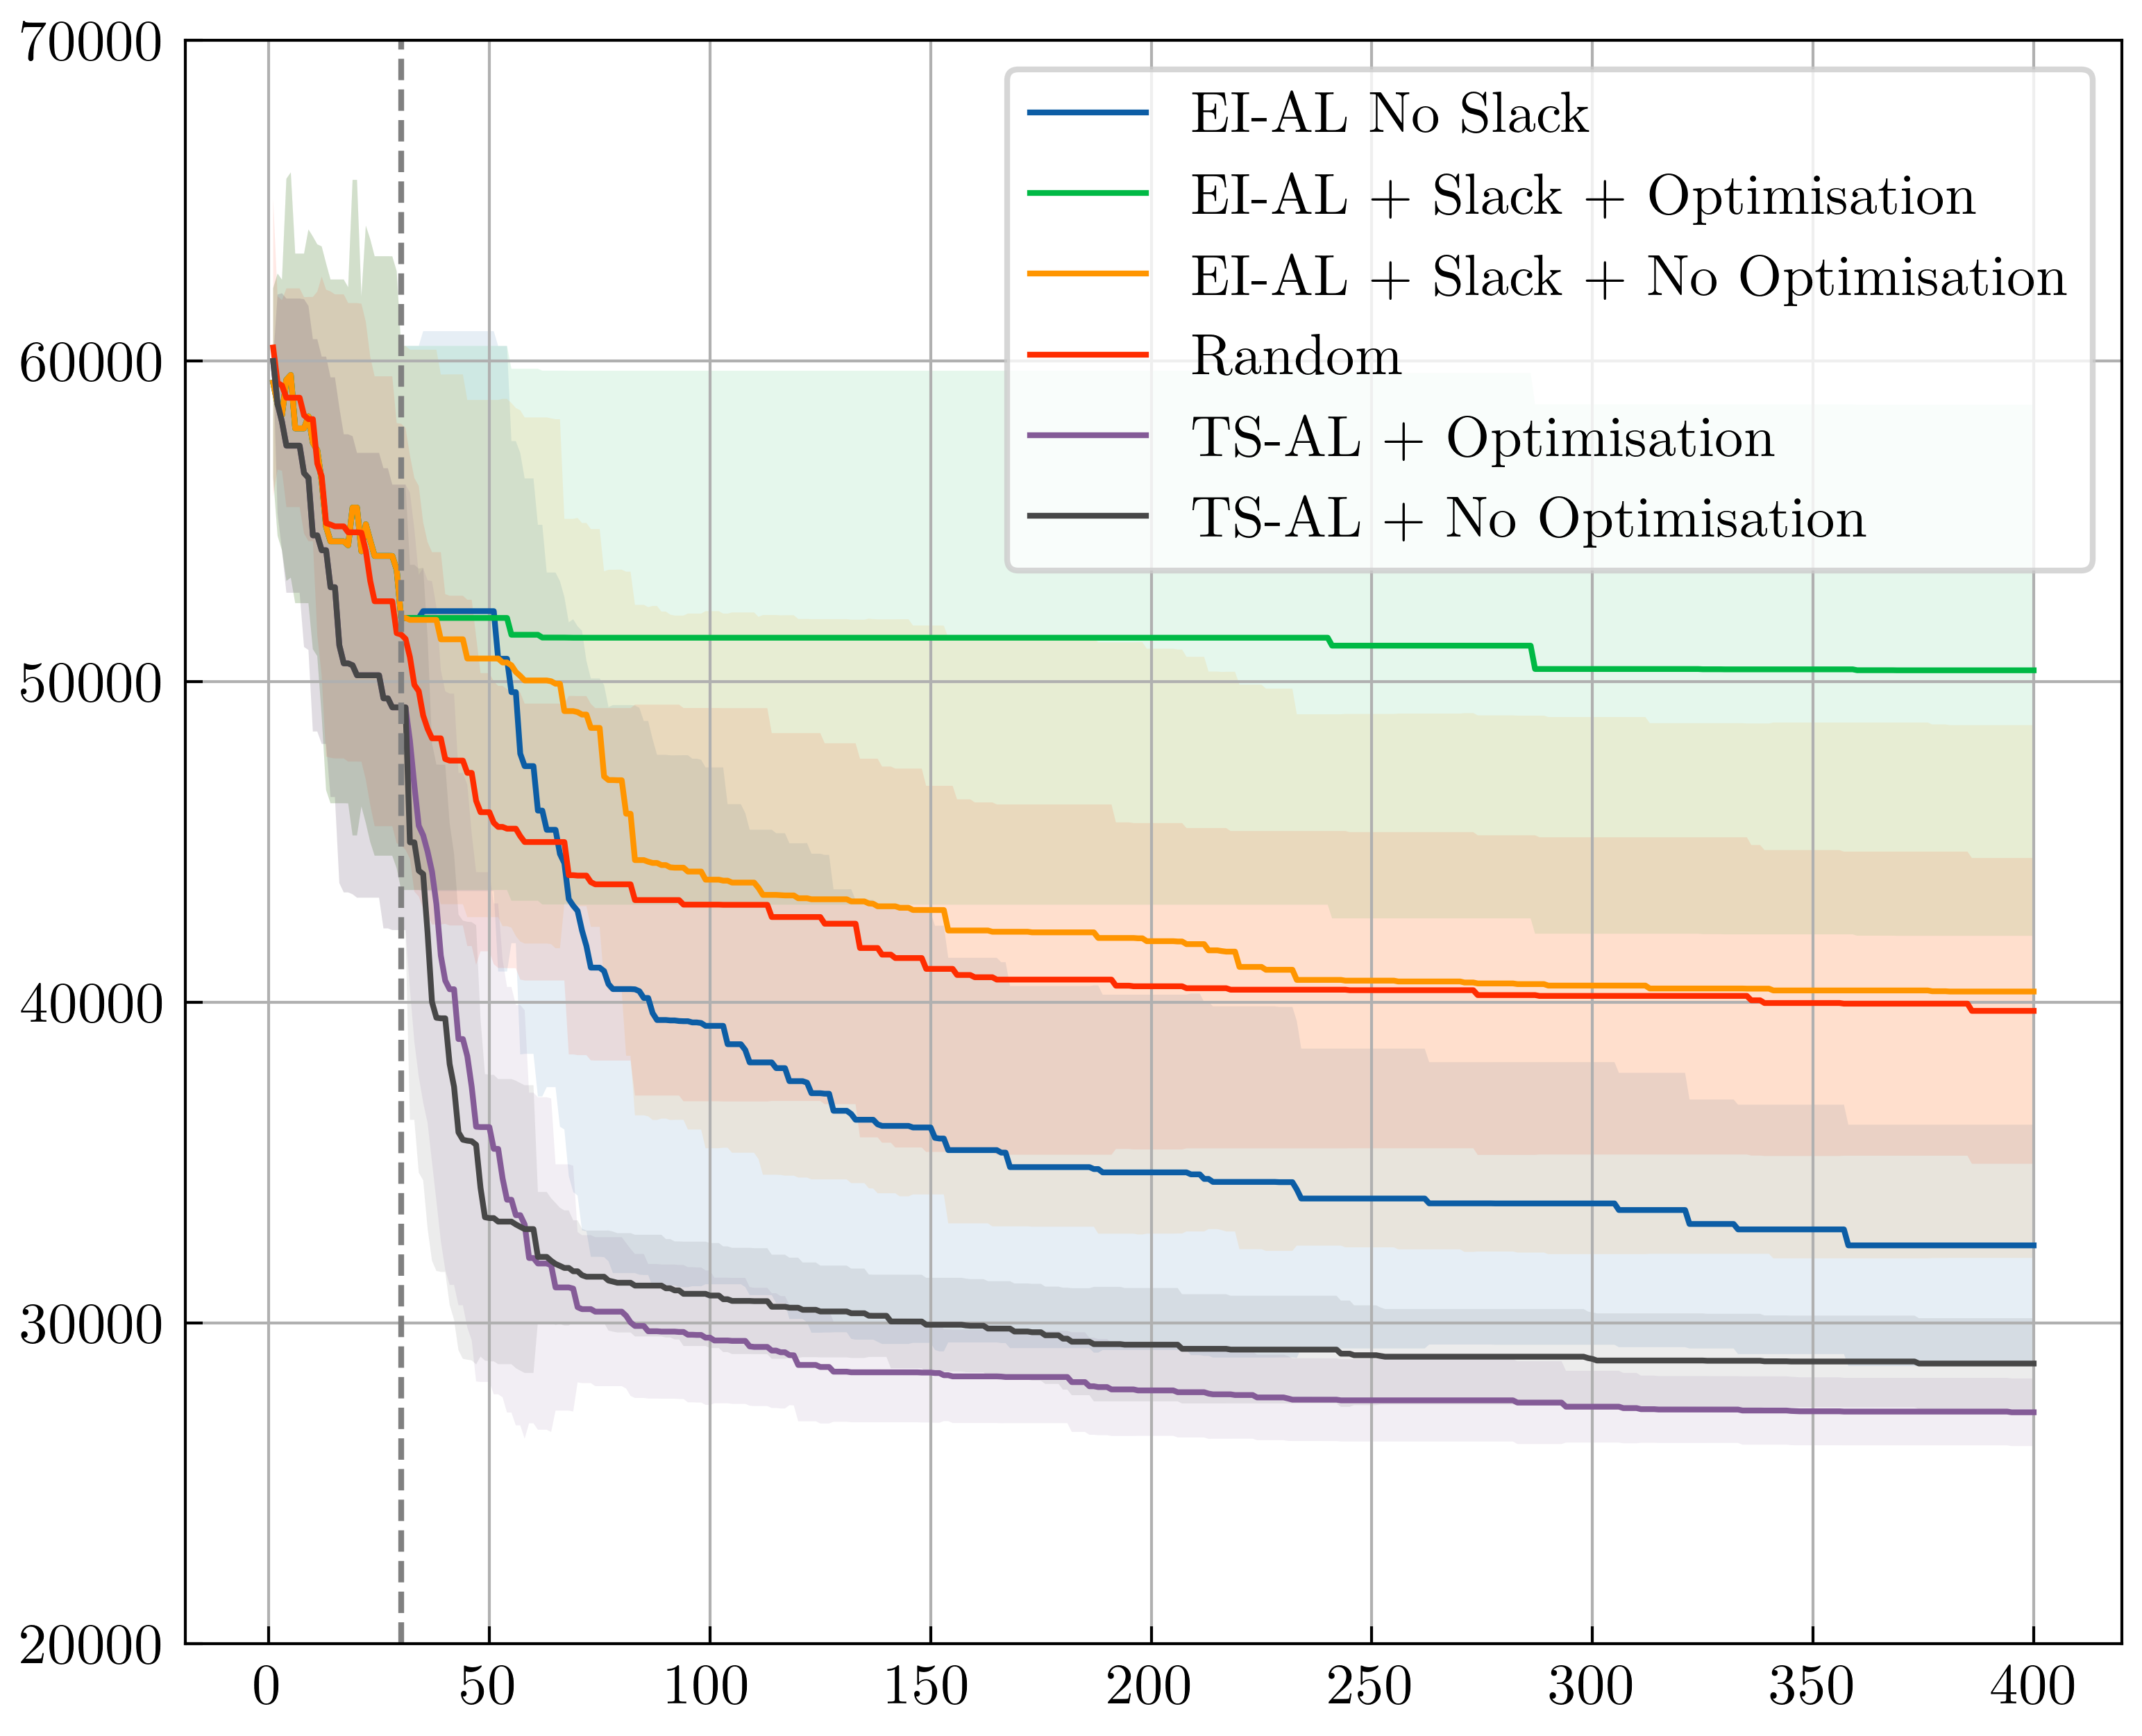

In [31]:
plt.figure(figsize=(6,5))
iters = [i for i in range(1, 401)]
plt.plot(iters, original_albo_no_slack_results_mean, label="EI-AL No Slack")
plt.plot(iters, original_albo_slack_optim_results_mean, label="EI-AL + Slack + Optimisation")
plt.plot(iters, original_albo_slack_no_optim_results_mean, label="EI-AL + Slack + No Optimisation")
plt.plot(iters, random_results_mean[:400], label="Random")
# plt.plot(ts_al_adam_results_mean, label="TS-AL + Adam")
# plt.plot(ts_al_adam_no_prev_results_mean, label="TS-AL + Adam No Prev")
plt.plot(iters, ts_al_adam_no_prev_rbf_results_mean, label="TS-AL + Optimisation")
plt.plot(iters, ts_al_random_rbf_results_mean, label="TS-AL + No Optimisation")
plt.axvline(x=30, color='grey', linestyle='--')
plt.fill_between(iters, original_albo_no_slack_results_mean+original_albo_no_slack_results_std, original_albo_no_slack_results_mean-original_albo_no_slack_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, original_albo_slack_optim_results_mean+original_albo_slack_optim_results_std, original_albo_slack_optim_results_mean-original_albo_slack_optim_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, original_albo_slack_no_optim_results_mean+original_albo_slack_no_optim_results_std, original_albo_slack_no_optim_results_mean-original_albo_slack_no_optim_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, random_results_mean[:400]+random_results_std[:400], random_results_mean[:400]-random_results_std[:400], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, ts_al_adam_no_prev_rbf_results_mean+ts_al_adam_no_prev_rbf_results_std, ts_al_adam_no_prev_rbf_results_mean-ts_al_adam_no_prev_rbf_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, ts_al_random_rbf_results_mean+ts_al_random_rbf_results_std, ts_al_random_rbf_results_mean-ts_al_random_rbf_results_std, alpha=0.1, linestyle='-', linewidth=2)
# plt.plot(ts_results_mean * 10000)
# plt.plot(ts_reduced_lbfgs_results_mean[:400] * 10000, label="TS-AL + L-BFGS-B")
# plt.plot(ts_no_optim_results_mean[:400] * 10000, label="TS-AL No Optim")
plt.ylim(20000, 70000)
plt.legend()